# NIH.AI ML Workshop-1a

## Machine Learning for Predicting Drug Function Using Molecular Structures
S.Ravichandran
(ravichandrans at mail dot nih dot gov)

## 1. Preliminary Information and software setup

For today, we are going to use a dynamic version of the workshop via BINDER cloud instance. If you want to run this workshop Python Notebook from your computer, then follow the [click on this link](Supp-ipynb/preliminary-information.ipynb). The link will give you the
preliminary information about the workshop and will also provide you with a list of Python libraries needed.  

We will use the following manuscript as a testcase to explain the Machine-Learning concepts:

https://www.ncbi.nlm.nih.gov/pubmed/31518132

Overview of the work:
*  Chemical structures with MeSH derived therapeutic drug classes are the inputs. 
*  **Random Forest (RF)** Machine-Learning (ML) method and **Convolution Neural Network** was used for classification. For this workshop, we fill focus on RF for this workshop.

**Run all codes from here to avoid seeing missing library related error messages**

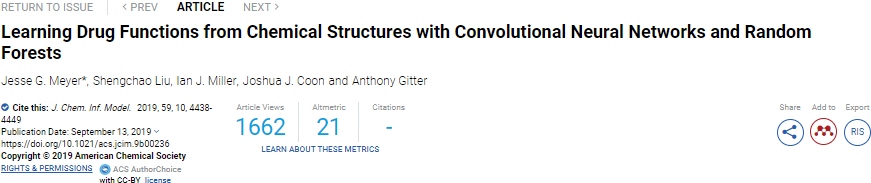

In [1]:
## Start running the code chunks from here 
from IPython.display import Image
Image('Img/RFPaper.png')

## 2. Drug Discovery Overview

Please [click on this link](Supp-ipynb/drugdiscovery.ipynb) to view a brief description of the drug-discovery process.

## 3. Modeling process overview 

In [2]:
from IPython.display import Image
# Ignore warnings (see SciPy issue #5998; code from Geron )
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Here is a schematic overview of the modeling procedure

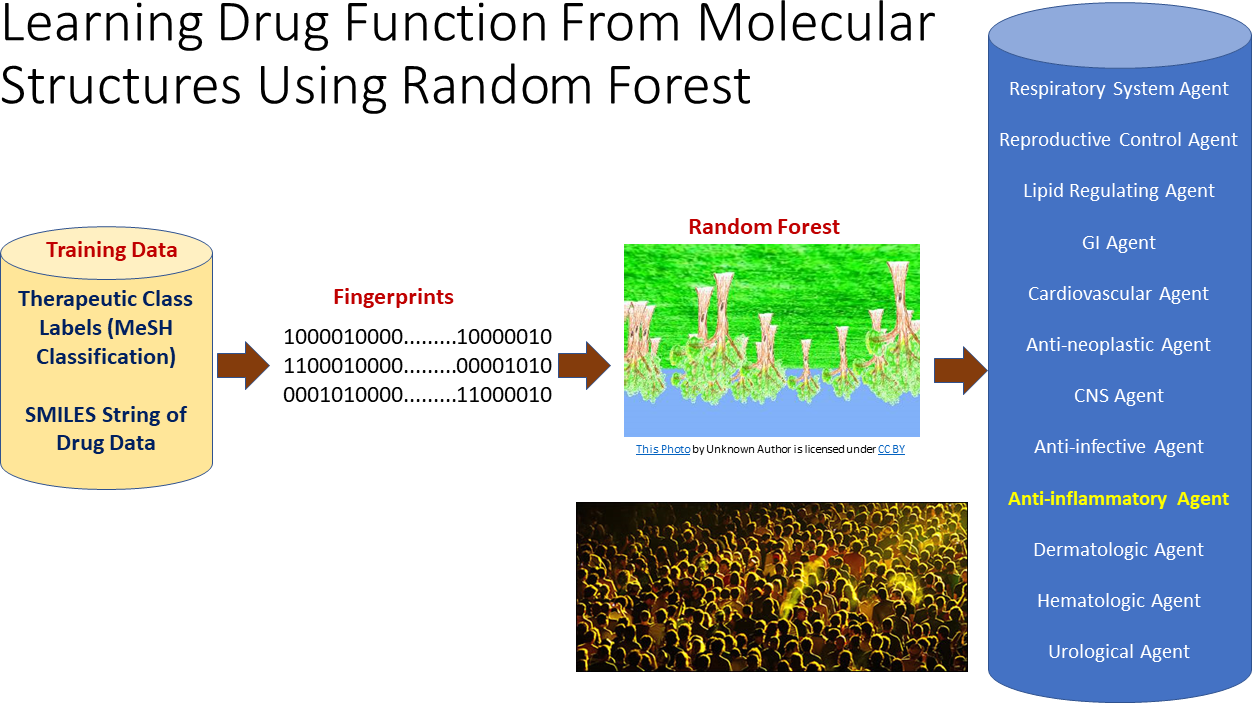

In [3]:
from IPython.display import Image
Image('Img/DrugFunctionModeling-banner.png')

## Goal of the work, https://www.ncbi.nlm.nih.gov/pubmed/31518132

(quote from paper)

**<font color=brown>
Our goal was to assess whether <font color =blue> <span style="text-decoration:underline">drug function classifier models</span></font> trained with readily-available <font color =blue><span style="text-decoration:underline">chemical structure input</span></font> can outperform models trained with empirical measures of drug effects. Our results support the effectiveness of chemical structure-based models.</font>**

### To create drug function classifier models, we need two things:

* Chemical structures and their associated class labels
* Descriptors (Fingerprints)

Let us see how we can extract chemical structures and their associated class labels from public small molecule database, PubChem. Once we have the SMILES strings, we can extract fingerprints. Let us start with SMILES strings

## 4. How to construct the SMILES drug dataset?

Please note that Meyer et al paper provides a broad summary of input data construction. In this tutorial, I have given the details of the process. Please note due to database updates, search results might be different. Please [click here](Supp-ipynb/pubchemdata.ipynb) to see details on how to construct the dataset.

## 5. Python library setup

Before you begin, make sure you are in the correct folder/directory. Not important for the workshop; but when you work on your own installation 
this will become important 

In [4]:
import os
# uncomment (remove the # sign and run the cell)
os.getcwd()

'C:\\Users\\ravichandrans\\Documents\\GitHub\\SRWkshp1a'

#### Load the libraries

In [5]:
import random 
import time
import numpy as np
import matplotlib.pyplot as plt

from collections import Counter

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE

RDKit WARNING: [09:03:38] Enabling RDKit 2019.09.3 jupyter extensions


In [6]:
# plot preferences
# plt.rcParams

## 6. Load the data 

In [7]:
import pandas as pd
# df = pd.read_csv("Data/media_3.csv")
# df3a = pd.read_csv('Data/3cls_aliper.csv')
df3  = pd.read_csv('Data/3cls_rmsaltol.csv')

# five class dataset
# df5a = pd.read_csv('Data/5cls_aliper.csv')
df5  = pd.read_csv('Data/5cls_rmsaltol.csv')

# 12 class dataset
# df12a = pd.read_csv('Data/12cls_aliper.csv')
# df12  = pd.read_csv('Data/12cls_rmsaltol.csv')

print("Here are few first/last 5 lines of the df3 data")
df3

Here are few first/last 5 lines of the df3 data


,pngpath,class,smiles
0,cns/1,cns,O=C1CC=CO1
1,cns/2,cns,CCC(=O)O[C@@]1(c2ccccc2)C[C@H](C)N(C)C[C@H]1C
2,cns/3,cns,C=CCC(N)C(=O)O
3,cns/4,cns,CC[C@@]12CCN(CC3CC3)[C@@H](C(=O)c3ccc(O)cc31)C2C
4,cns/5,cns,c1csc(C2(N3CCCCC3)CCCCC2)c1
...,...,...,...
3099,cardio/783,cardio,CN=C(NCc1ccccc1)[NH2+]C.CN=C(NCc1ccccc1)[NH2+]C
3100,cardio/784,cardio,CC1O[C@@H](O[C@@H]2C=C3CC[C@@H]4[C@H](CC[C@]5(...
3101,cardio/785,cardio,O=C(Nc1ccc(C([O-])=Nc2cc(S(=O)(=O)[O-])cc3cc(S...
3102,cardio/786,cardio,CCC(=O)OC(OP(=O)(CCCCc1ccccc1)CC(=O)N1CC(C2CCC...


### Explore the dataset

In [8]:
# All the data
print('Dimension of 3-class dataset', df3.shape)
print('Dimension of 5-class dataset', df5.shape)
# print('Dimension of 12-class dataset', df12.shape, '\n')

# Subset of data 
# print('Dimension of 3-class subset dataset', df3a.shape)
# print('Dimension of 5-class subset dataset', df5a.shape)
# print('Dimension of 12-class subset dataset', df12a.shape, '\n')

Dimension of 3-class dataset (3104, 3)
Dimension of 5-class dataset (5760, 3)


#### **Assign a specific dataset for modeling/analysis?**

For choosing a 3-class data, use 
``` df = df3 ```

For choosing a 5-class data, use ``` df = df5 ```

For now, we are going to use ```3-class data``` for modeling. 

In [9]:
## Assign a dataset for analysis
df = df3

## 7. Explore the data

In [10]:
# print(df.info)
# df.describe()
print(df['class'].value_counts(),"\n")

# any missing values
print("Any missing values? ", pd.isnull(df).any())

antineoplastic    1177
cns               1139
cardio             788
Name: class, dtype: int64 

Any missing values?  pngpath    False
class      False
smiles     False
dtype: bool


## 8. Prepare the data for modeling

Create SMILES data (x) and outcome class (outcome)

In [11]:
x = df['smiles'].values

mols1 = [Chem.MolFromSmiles(smi) for smi in x]
outcome = df['class'].values

print(outcome)

['cns' 'cns' 'cns' ... 'cardio' 'cardio' 'cardio']


### Encode Outcome (target) Labels to Integers

Encode target labels with value between 0 and n_classes-1.
See here for more information, https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [12]:
# from sklearn 
print('outcome:  ', outcome)
le = preprocessing.LabelEncoder()
le.fit(outcome);
print('What labels are available in classes?:', list(le.classes_))
ys_fit = le.transform(outcome)

print('transformed outcome:  ', ys_fit)

outcome:   ['cns' 'cns' 'cns' ... 'cardio' 'cardio' 'cardio']
What labels are available in classes?: ['antineoplastic', 'cardio', 'cns']
transformed outcome:   [2 2 2 ... 1 1 1]


### Explore the data to see the label to Integer association 

We do this by taking few labels 

In [13]:
# for a 3 class random samples
temp = [1, 501, 1002, 1590, 1750, 2001, 2500, 2902, 3050]

# for a 5 class 
# temp = [1, 2 ,201, 202, 250, 301, 302, 401, 402, 577]

print('Ten outcome values', outcome[temp])
print('And their corresponding encoded outcome values', ys_fit[temp],'\n')

Ten outcome values ['cns' 'cns' 'cns' 'antineoplastic' 'antineoplastic' 'antineoplastic'
 'cardio' 'cardio' 'cardio']
And their corresponding encoded outcome values [2 2 2 0 0 0 1 1 1] 



From the above analysis, for a 3-class, df3a data, we see that 
```
0: Antineoplastic Agents (antineoplastic)
1: Cardiovascular Agents (cardio)
2: Central Nervous System Agents (cns)
```
If we repeat  the analysis for a df5a dataset, we will see the followign associations
```
0: Anti Infective Agents
1: Antineoplastic Agents
2: Cardiovascular Agents
3: Central Nervous System Agents
4: Gastrointestinal Agents
```

## 9. Data  Analysis 

Let us answer the following questions: 

* How many Classes/Samples? 
* Is this a balanced outcome data?

In [14]:
bin_count = np.bincount(ys_fit)
n_classes = len(bin_count)
print('How many classes? ',n_classes)
print('How many samples? ', len(ys_fit) )

print('How many from each class (raw numbers)? ', bin_count )
print('How many from each class (proportions)?: ', bin_count/(sum(bin_count)))

How many classes?  3
How many samples?  3104
How many from each class (raw numbers)?  [1177  788 1139]
How many from each class (proportions)?:  [0.37918814 0.25386598 0.36694588]


In [15]:
## Can we convert the values into OneHotEncoder 
# from sklearn.preprocessing import OneHotEncoder
# encoder = OneHotEncoder()
# ys_fit_1hot = encoder.fit_transform(ys_fit.reshape(-1,1))
# ys_fit_1hot
# ys_fit_1hot.toarray()
# print(ys_fit_1hot.toarray().shape)
# print(x.shape)

## 10. Generate fingeprints: Morgan 1024 bit connectivity molecular fingerprints

Read the following paper for details, https://www.ncbi.nlm.nih.gov/pubmed/20426451

### Create fingerprints for each molecules

In [16]:
# Time to generate the Fingerprints: 8.323498249053955 seconds on core i7 laptop

time_start = time.time()

from rdkit.Chem import AllChem
fp1 = [AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024) for m in mols1]

# convert RDKit explicit vectors into NUMPY array
np_fps = np.asarray(fp1)

time_elapsed = time.time()-time_start
txt = 'Time to generate the Fingerprints: {} seconds '
print(txt.format(time_elapsed))

print(np_fps)

Time to generate the Fingerprints: 7.091792345046997 seconds 
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


In [17]:
# Get the dimensions of np_fps array
np_fps.shape

(3104, 1024)

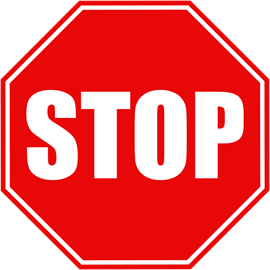

In [18]:
Image(filename ="Img/stop.png",width=100)

<font color =blue>Make sure you understand the completed steps before you move to the next task </font>

To summarize, we have the following data:
* Fingerprints, **np_fps**
* Encoded numerical variable, **ys_fit**

## 11. Unsupervised Learning: 

### Exploratory Data Analysis (EDA)

## t-Distributed Stochastic Neighbor Embedding (t-SNE) for Dimension Reduction and analysis

The goal for today is not to explain the details of t-SNE. You can check for some preliminary details here, [here](Supp-ipynb/tsne.ipynb) and 
here, https://lvdmaaten.github.io/tsne/

Here is a short comparison between t-SNE and PCA

* Both techniques are used for dimensionality reduction (feature selection/extraction/elimination)
* tSNE is newer technique compared to PCA

PCA: 
    * It is a linear method and it maps the data to a lower-dimensional space such that the variance of the data in the low-dim representation is maximized.

* t-SNE 
    * Non-linear technique. Compares probabilities (conditional) of similarity of neighboring points in high dimensional space to the low-dimensional space. t-SNE does this using Kullback-Leibler (KL) divergence. Follow the link for details, http://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf

## Important points about t-SNE implementation in Scikit-Learn

Detailed documentation link: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

* **fit_transform**: Note that t-SNE has no separate **fit** and **transform** methods. TSNE
does both at the same time making it impossible to add new data points

* **perplexity paramter**: This strives to achieve a balance between the two distributions. 
This is a guess about the number of close neighbors (default is 30 in Scikit Learn). Obviously
it has to be lower than the number of input data size 

* **Random component** Orientation of the plot might be different. But, the relative distances between samples will be the same

* **Learning rate:** Identifying the best value is by trial and error (best option 50 to 200; but the accepted range is 10 to 1000). Note as we will learn later, Learning rate is a hyperparameter. 

* **List of other HyperParameters:** perplexity, early_exaggeration, learning_rate, n_iter

Final note: Please understand that t-SNE is stochastic (non-deterministic). 

What does this mean: 
Hyper Paramter combination of two runs will produce different results.  We can control this using random_state (seed value)

## Work on the following t-SNE code chunks (10 minutes)

### t-SNE try-1

Note, NIH HPC with CANDLE is suitable for Hyper Parameter Optimization (will be discussed later). 

In [19]:
## Warning: core i7 Windows OS this code chunk took 
## t-SNE with LR=50, n_comp = 2! Time elapsed: 42 seconds
time_start = time.time()

# you can try this if you have time 
# in my laptop it took
# t-SNE with LR=50, n_comp = 2! Time elapsed: 725 seconds
# model = TSNE(learning_rate=200, perplexity=50, 
#              n_iter=1300, early_exaggeration=20, 
#              method='exact')


# t-SNE with LR=50, n_comp = 2! Time elapsed: 41.983298540115356 seconds
model = TSNE()
transformed = model.fit_transform(np_fps)

xs = transformed[:,0]
ys = transformed[:,1]

time_elapsed = time.time()-time_start

txt = 't-SNE with LR=50, n_comp = 2! Time elapsed: {} seconds'
print(txt.format(time_elapsed))

t-SNE with LR=50, n_comp = 2! Time elapsed: 53.616647720336914 seconds


### Let us plot the data

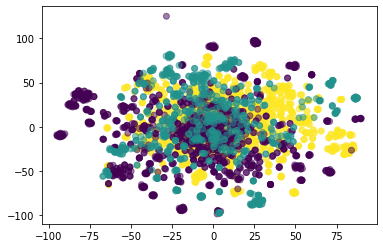

In [20]:
plt.scatter(xs, ys, c = ys_fit, alpha = 0.5);

<div class="alert alert-success">
    <b>Exercise-1: Trying other t-SNE options </b>:
     <ul>
      <li>
Try different learning_rates (Warning: Time consuming) and other parameters.
          For example, learning_rate=50, n_components=3
      </li>
    </ul>
</div>

<div class="alert alert-info">
    <b> Exercise-1: Solution: Try on your own. If you want to see a solution, uncomment the following line by removing the pound (#) sign and run it.
        This will reveal the code. To execute the code, rerun it again </b>
</div>

In [21]:
# %load Solutions/solutions1.py
## Warning: core i7 Windows OS this chunk took 
# t-SNE with LR=50, n_comp = 3! Time elapsed: 99.83587741851807 seconds

Let us try plotting different components 

<div class="alert alert-success">
    <b>Exercise-1a: Continuation from previous cell/chunk command:  </b>:
     <ul>
      <li>
Trying plotting other lower dimensional components (1 vs 3, 2  vs 3)
      </li>
    </ul>
</div>

<div class="alert alert-info">
    <b> Exercise-1a Solution:Try on your own. If you want to see a solution, uncomment the following line by removing the pound (#) sign and run it. </b>
</div>

In [22]:
# %load Solutions/solutions2.py

### Unlike the commonly used Iris data set we see no clear separation.    
Let us continue with PCA and we will revisit this question later

## 12. Principal Component Analysis (PCA)

Let us do some prepreparation. 

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(np_fps)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [24]:
print(principalDf.shape)
print(df.shape)

# principalDf.to_csv("principalDf.csv")
finalDf = pd.concat([ principalDf, df[['class']] ], axis = 1)

# finalDf.head
# finalDf.to_csv("finalDf.csv")
df.head()

(3104, 2)
(3104, 3)


,pngpath,class,smiles
0,cns/1,cns,O=C1CC=CO1
1,cns/2,cns,CCC(=O)O[C@@]1(c2ccccc2)C[C@H](C)N(C)C[C@H]1C
2,cns/3,cns,C=CCC(N)C(=O)O
3,cns/4,cns,CC[C@@]12CCN(CC3CC3)[C@@H](C(=O)c3ccc(O)cc31)C2C
4,cns/5,cns,c1csc(C2(N3CCCCC3)CCCCC2)c1


In [25]:
# class
finalDf.columns
le.classes_

array(['antineoplastic', 'cardio', 'cns'], dtype=object)

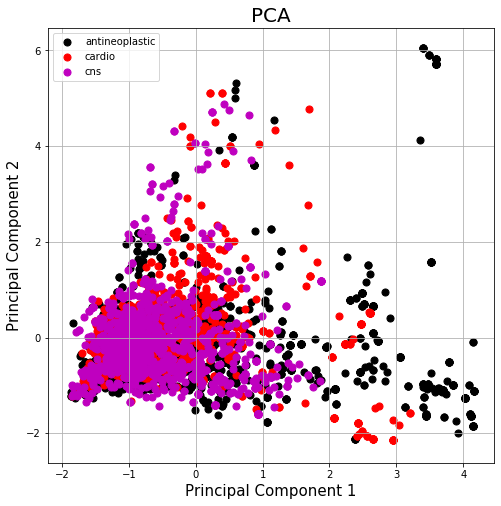

In [26]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)
targets = list(le.classes_)

colors = ['k','r','m','y','b','g','c',
          'olive','navy','indigo','brown','crimson']
for target, color in zip(targets, colors):
    indicesToKeep = finalDf['class'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

<div class="alert alert-info">
    <b> Exercise-2: Take Home Exercise:   </b>:
     <ul>
      <li>
Repeat the modeling with 5 class and 12 class data. Compare the t-SNE and PCA results.
      </li>
    </ul>
</div>

### Exercise-2: Solution: 

Please scroll up to the ```Let us explore the data``` code chunk and replace ```df``` by the appropriate dataframe (```df5``` for 5-class and ```df12``` for 12-class; see below) and run all the code chunks up to this one.
```
# Scroll up to the **Let us explore the data** section
# change the following linke from 
# df = df3 to df = df5 
df = df5 
# run all the code chunks up to this one
```

### Following the recommendation of Scikit-learn, can we also combine PCA with t-SNE? 

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

<div class="alert alert-info">
    <b>Exercise-2a: Take Home Exercise:   </b>:
     <ul>
      <li>
Let us do PCA and select components that can explain 0.95 of variance and feed the data into t-SNE. This procedure could be useful for some datasets.
      </li>
    </ul>
</div>

In [27]:
# %load Solutions/solutions3.py

### Does PCA/t-SNE work for all datasets?

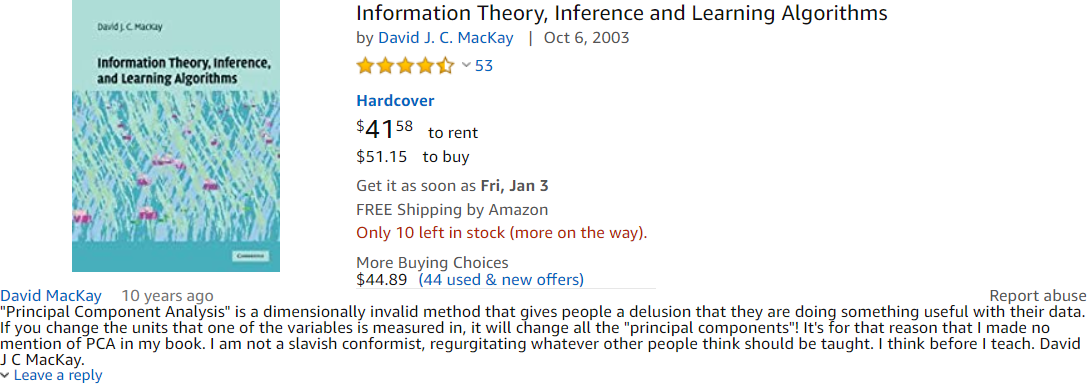

In [28]:
Image('Img/amazonreview1.png')

## 13. Getting ready to do modeling 

First, let us split the data

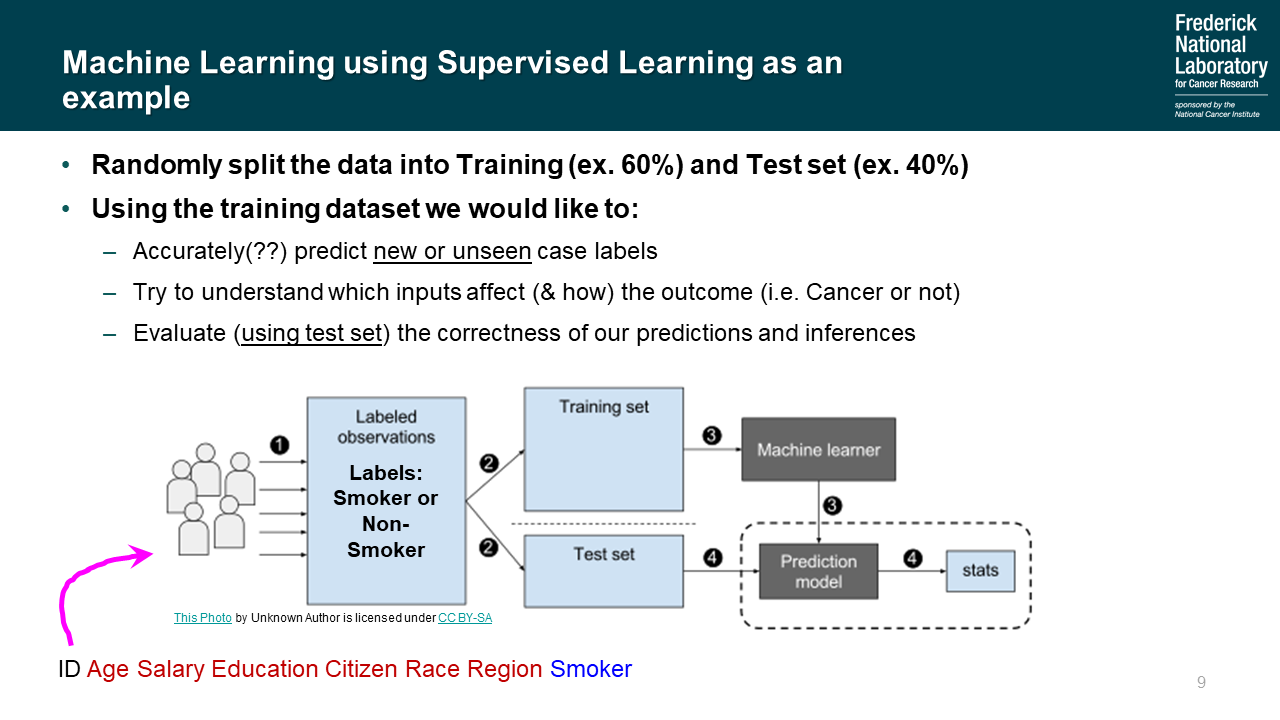

In [29]:
Image('Img/TrainTestSplit.png')

In [30]:
from sklearn.model_selection import train_test_split

print(np_fps.shape)
print(x.shape)

train_X, test_X, train_y, test_y = train_test_split(np_fps, ys_fit, 
                                                    train_size=0.75,
                                                    test_size=0.25,
                                                    random_state=123,
                                                    stratify = ys_fit)
train_y = list(train_y)
test_y = list(test_y)

(3104, 1024)
(3104,)


### Explore the proportion of outcomes to answer questions about data imbalance

In [31]:
# Even outcome for this class
np.bincount(ys_fit)/len(ys_fit)

array([0.37918814, 0.25386598, 0.36694588])

## 14. Supervised Learning using Random Forest

#### Why we are focussing on Random Forest?

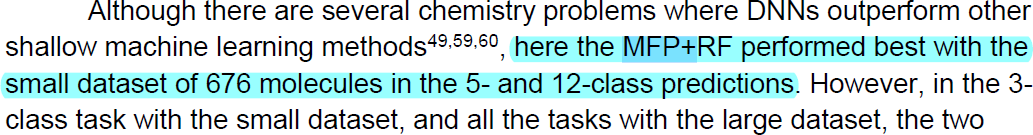

In [32]:
Image('Img/PaperSummary1.png')

## 15. Tree-based Modeling basics

Please [click](Supp-ipynb/TreebasedMethods.ipynb) here to see a brief summary of tree-based modeling methods 

## 16. Classification Trees

 * **Objective**: In this case, to infer labels of the new drug data
 * Trees work by series of if-else statements using each variable
 * Trees can capture non-linear relationships between features and outcomes
 * Advantages: No need for scaling (or standardization)

## 17. Random Forest: Try1

In [33]:
# get a random forest classifiert with 100 trees
rf = RandomForestClassifier(n_estimators=50, random_state=1123)

#### Import parameters

* max_depth 
* bootstrap
* n_estimators
* min_samples_leaf
* min_samples_split

In [34]:
from pprint import pprint
# View the parameters of the random forest
print('Parameters will be used for this model:\n')
pprint(rf.get_params())

Parameters will be used for this model:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1123,
 'verbose': 0,
 'warm_start': False}


In [35]:
# train the random forest

rf.fit(train_X, train_y);

In [36]:
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score

pred_y = rf.predict(test_X)
acc = metrics.accuracy_score(test_y, pred_y)
print("Test set accuracy: {:.2f}".format(acc))

balanced_acc_score = balanced_accuracy_score(test_y, pred_y)
print("Balanced set Accuracy Score: {:.2f}".format(balanced_acc_score))


Test set accuracy: 0.87
Balanced set Accuracy Score: 0.86


Normalized confusion matrix
[[0.901 0.014 0.085]
 [0.076 0.756 0.168]
 [0.081 0.011 0.909]]


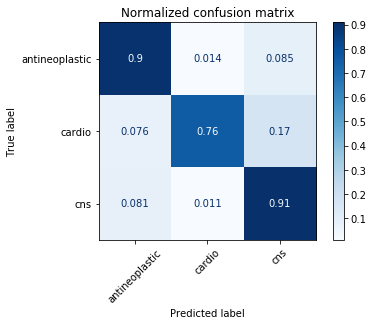

In [37]:
# Plot non-normalized confusion matrix
# get a random forest classifiert with 100 trees
np.set_printoptions(precision=3)
from sklearn.metrics import plot_confusion_matrix

# if you want to see unnormalized with normallized 
# titles_options = [("Confusion matrix, without normalization", None),
#                   ("Normalized confusion matrix", 'true')]
titles_options = [("Normalized confusion matrix", 'true')]

for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, test_X, test_y,
                                 display_labels=le.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    plt.xticks(rotation=45)
    
    print(title)
    print(disp.confusion_matrix)

plt.show()

## 18. How can we improve the models?
There are several parametes (number of estimators, maximum features etc.) that could be assigned different values. 
These parameters are commonly referred to as Hyperparameters. Choosing the right combination is called HyperParameter 
Optimization (HPO). Let us briefly go through the basics of hyperparameters/HPO.

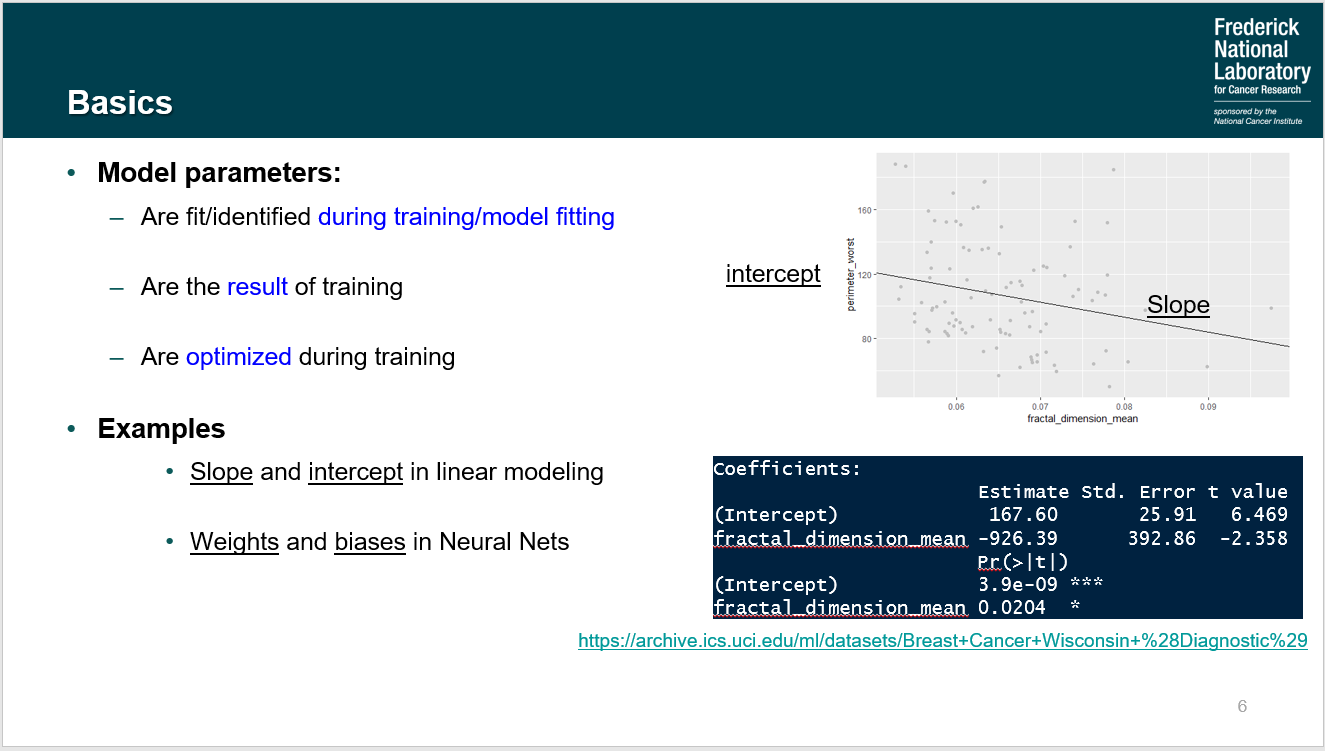

In [38]:
from IPython.display import Image
Image('Img/HPO-1.png')

Summary of HPO

* We can try different combinations to find the optimal setting based on the performance of the models
* Usually HPO is used with CV to avoid overfitting

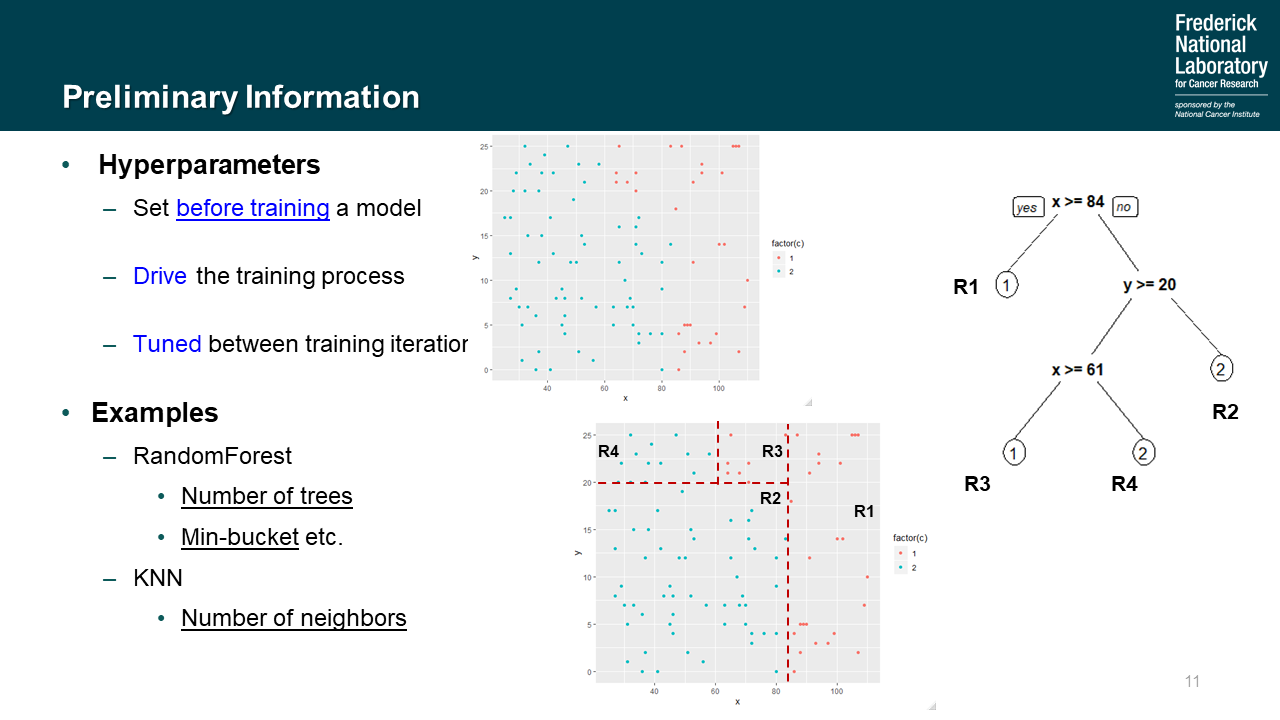

In [39]:
from IPython.display import Image
Image('Img/HPO-2.png')

## 19. Hyperparameter values (HP) and HP Optimization (HPO) 

Libraries from different languages have different HP values. For ScikitLearn implementation of RandomForest, we can adjust several HP values. Here is the complete list:

```
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1123,
 'verbose': 0,
 'warm_start': False}
 ```

Where do we start? The best option is to read the documentation, https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html. We have adopted the following choices based on the manuscript. 

**n_estimators**: Number of trees in the forest
* Example [200, 400, 600, 800, 1000, 12000, 1400, 1600, 1800, 2000]


**max_features**: Maximum number of features to consider when looking for the best split 
* If **auto**, then **max_features**=sqrt(**n_features**) [same as **sqrt** option]
* If **log2**, then **max_features**=log2(**n_features**).
* Ex. ['None', 'sqrt', 'log2']

**max_depth**: Maximum number of levels in each decision tree. 
* We could try the following options: [10, 20, ..., 110]
    

**min_samples_leaf**: Minimum number of samples required to be at a leaf node. 
    - Ex. [1, 2 and 4]
    
**bootstrap**: Method for data sampling (with or without replacement)
* [True, False]

**min_samples_split**: [2, 5, 10]

| Parameter | Values   |
|----------|----------|
|  n_estimators  | 50, 250, 1000, 4000, 8000, 16000|
| max_features   | sqrt, log2 | 
| min_samples_leaf| 1, 10, 100, 1000 | 
| class_weight |  None, balanced_subsample, balanced| 


A HPO ```RandomizedSearchCV``` run was carried out in NIH HPC with the list shown in the table and found the following best combination. 

| Parameter | Values   |
|----------|----------|
|  n_estimators  | 8000 |
| max_features   | log2 | 
| min_samples_leaf| 1 | 
| class_weight |  balanced| 


We then used the best parameters to train the full training set and tested the model with the test set to get a balanced accuracy score of 0.87 (a small improvement from the previous tests).

NIH HPC was used for testing (3 class problem) with the following configuration: ```--cpus-per-task=8```. The run took about 1.45 G max memory/cpu and less than an hour. 

## 20. CANDLE 

HPO can be efficiently carried out using CANDLE. 

What is CANDLE?

"CANDLE (CANcer Distributed Learning Environment) is an open-source software platform providing deep learning methodologies that scales very efficiently on the world’s fastest supercomputers." More details here, https://hpc.nih.gov/apps/candle/

A candle HPO script for the 3-class modeling using the data from the paper is available in NIH Biowulf HPC. Workshop attendees will receive an email with the file location. 

Note that the CANDLE script will use a custom conda environment that includes the chemoinformatics libraries used in this workshop. 

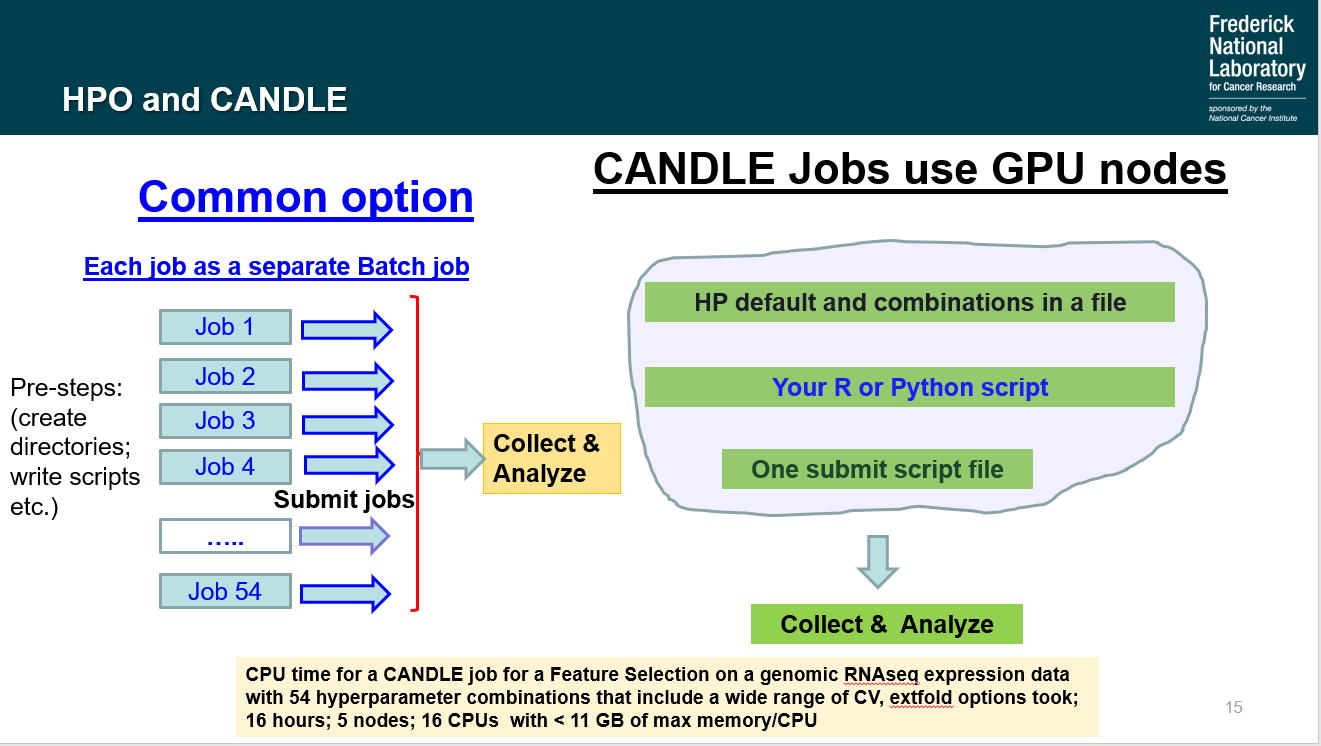

In [40]:
Image(filename='Img/Candle-1.png')

**Acknowledgements:** Drs. George Zaki, Andrew Weisman and Eric Stahlberg. I would also like to thank FNLCR/BIDS colleagues for reviewing the materials.